## Connor Contursi

# Configure Defaults

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define paths to model files
import os

MY_PATH = "/DPL"
GDRIVE_PATH = "/content/drive/My Drive/DPL/"
GDRIVE_GARBO = "/content/drive/" + "MyDrive/" + "DPL/"
MODELS_DIR = GDRIVE_GARBO
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + "model"
MODEL_NO_QUANT_TFLITE = MODELS_DIR + "model_no_quant.tflite"
MODEL_TFLITE = MODELS_DIR + "model.tflite"
MODEL_TFLITE_MICRO = MODELS_DIR + "model.cc"

In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

# Numpy is a math library
import numpy as np

# Pandas is a data manipulation library
import pandas as pd

# Matplotlib is a graphing library
import matplotlib.pyplot as plt

# Math is Python's math library
import math

# SKlearn for reporting precision, recall, confusion matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# Dataset

In [4]:
from tqdm import tqdm

path = "/content/drive/My Drive/Data"

# ----------------------------------------------------------------------------------

# Initializes individual data sets
class_wave = pd.DataFrame()
class_fistbump = pd.DataFrame()
wave_files = 0
fist_files = 0

# Strings used to open the correct files
wave_match = "wave"
fist_match = "fist"

# Counts all the files in a given directory.
initial_count = len(
    [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
)
dirre = os.listdir(path)
file_count = 2 * len(dirre)

# Iterates through the directory and compiles data for waves and fist bumps.
# Also displays a progress bar at the bottom which keeps track of work done.
with tqdm(total=file_count) as pbar:
    for subdir, dirs, files in os.walk(path):
        for file in files:
            os.chdir(subdir)

            # Checks for wave file and then pulls data
            if wave_match in file.lower():
                pbar.update(1)  # Increment the progress bar
                wave_array = np.genfromtxt(
                    file,
                    delimiter=",",
                    dtype=np.float32,
                    usecols=range(6),
                    skip_header=1,
                )
                wave_array = wave_array.reshape(50, 119 * 6)
                wave_data_array = pd.DataFrame(wave_array)
                class_wave = pd.concat([class_wave, wave_data_array])
                wave_files += 1

            # Checks for fist bump file and then pulls data
            if fist_match in file.lower():
                pbar.update(1)  # Increment the progress bar
                fist_array = np.genfromtxt(
                    file,
                    delimiter=",",
                    dtype=np.float32,
                    usecols=range(6),
                    skip_header=1,
                )
                fist_array = fist_array.reshape(50, 119 * 6)
                fist_data_array = pd.DataFrame(fist_array)
                class_fistbump = pd.concat([class_fistbump, fist_data_array])
                fist_files += 1

pbar.close()

# Combines all of class data for wave and fistbumps into single set
class_data = pd.concat([class_wave, class_fistbump])
samples, unused_y = class_data.shape
asserts = samples * unused_y
# ----------------------------------------------------------------------------------

# Creates y labels
y = np.zeros(samples)

for position in range(int(0.50 * samples), samples, 1):
    y[position] = 1

y = y.astype(np.float32)

100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


## Splitting Data

In [5]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT = int(0.6 * samples)
TEST_SPLIT = int(0.2 * samples + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(class_data, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) == asserts

# Design the Model

In [6]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(128, activation="relu", input_shape=(x_train.shape[1],)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer="adam", loss="mse", metrics=["mae"])

## Train the Model

In [7]:
history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_validate, y_validate),
)

Epoch 1/500
19/19 [==============================] - 1s 15ms/step - loss: 2369.8025 - mae: 32.3560 - val_loss: 351.3727 - val_mae: 13.8379
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 1798.5743 - mae: 23.7636 - val_loss: 416.3429 - val_mae: 15.2188
Epoch 3/500
19/19 [==============================] - 0s 5ms/step - loss: 980.0531 - mae: 18.0768 - val_loss: 268.8650 - val_mae: 12.1410
Epoch 4/500
19/19 [==============================] - 0s 5ms/step - loss: 742.9957 - mae: 15.4032 - val_loss: 252.7226 - val_mae: 11.8548
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 953.9948 - mae: 15.4458 - val_loss: 324.5500 - val_mae: 12.7405
Epoch 6/500
19/19 [==============================] - 0s 5ms/step - loss: 1342.2637 - mae: 15.8096 - val_loss: 241.5216 - val_mae: 11.9685
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 1744.5232 - mae: 15.3435 - val_loss: 245.4730 - val_mae: 11.4172
Epoch 8/500
19/19 [=================

# Plotting the Metrics

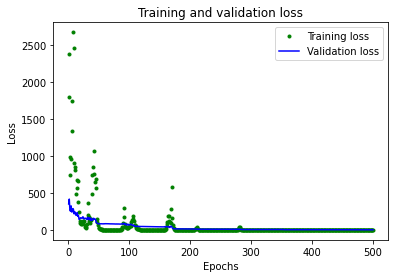

In [8]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, "g.", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

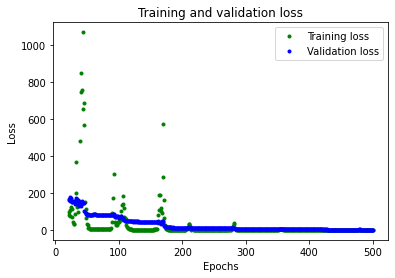

In [9]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], "g.", label="Training loss")
plt.plot(epochs[SKIP:], val_loss[SKIP:], "b.", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Larger Model

In [10]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation="relu", input_shape=(x_train.shape[1],)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation="relu"))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [11]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_validate, y_validate),
)


# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
19/19 [==============================] - 1s 12ms/step - loss: 456.1059 - mae: 13.7643 - val_loss: 165.3188 - val_mae: 9.7839
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 112.1249 - mae: 7.3564 - val_loss: 131.3467 - val_mae: 8.1475
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 59.0818 - mae: 5.2907 - val_loss: 105.3075 - val_mae: 7.4706
Epoch 4/500
19/19 [==============================] - 0s 3ms/step - loss: 45.2014 - mae: 4.4373 - val_loss: 101.0882 - val_mae: 7.3434
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 27.4326 - mae: 3.8778 - val_loss: 94.9321 - val_mae: 7.0865
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 22.2695 - mae: 3.4922 - val_loss: 92.8307 - val_mae: 7.0712
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 18.4293 - mae: 3.2258 - val_loss: 85.3544 - val_mae: 6.8638
Epoch 8/500
19/19 [==============================] - 0s 4ms/s

## Precision, Recall, F1 Score

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.48      0.65       400

    accuracy                           0.48       400
   macro avg       0.50      0.24      0.33       400
weighted avg       1.00      0.48      0.65       400



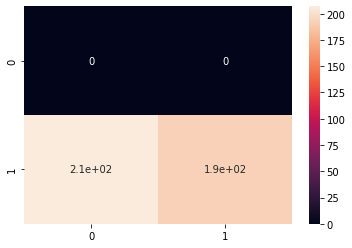

In [12]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
test_acc = model.evaluate(x_test, y_test, verbose=0)

y_probs = model.predict(x_test, verbose=0)
y_classes = (model.predict(x_test) > 0.5).astype("int32")

y_probs = y_probs[:, 0]
y_classes = y_classes[:, 0]

accuracy = accuracy_score(y_test, y_classes)
precision = precision_score(y_test, y_classes)
recall = recall_score(y_test, y_classes)
f1 = f1_score(y_test, y_classes)

matrix = confusion_matrix(y_test, y_classes)
print(metrics.classification_report(y_test, y_classes))

f = sns.heatmap(matrix, annot=True)

## Plotting the Metrics

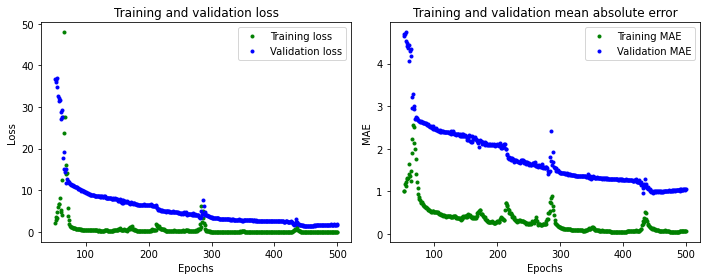

In [13]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], "g.", label="Training loss")
plt.plot(epochs[SKIP:], val_loss[SKIP:], "b.", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

plt.plot(epochs[SKIP:], train_mae[SKIP:], "g.", label="Training MAE")
plt.plot(epochs[SKIP:], val_mae[SKIP:], "b.", label="Validation MAE")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()

13/13 [==============================] - 0s 2ms/step - loss: 2.0316 - mae: 1.0064


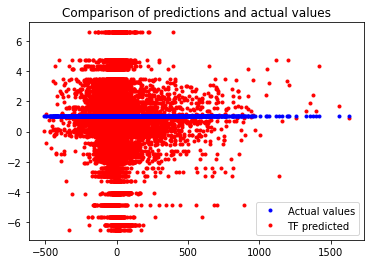

In [14]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

x_test = np.asarray(x_test).astype(int)
y_test = np.asarray(y_test).astype(int)

# y_test = np.array(y_test)
# #y_test_pred.to_numpy()
# Graph the predictions against the actual values
plt.clf()
plt.title("Comparison of predictions and actual values")
by = plt.plot(x_test, y_test_pred, "r.", label="TF predicted")
bx = plt.plot(x_test, y_test, "b.", label="Actual values")
plt.legend(handles=[bx[0], by[0]])
plt.show()

## Generating a TensorFlow Lite Model

In [15]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()
x_train.to_numpy().flatten()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
    for i in range(714):

        yield [x_train[i]]


# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

14160

## Compare Model Performance

In [16]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test = x_test.flatten()
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((400, 714))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred


def evaluate_tflite(tflite_model, x_test, y_true):
    global model
    y_pred = predict_tflite(tflite_model, x_test)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).numpy()
    return loss

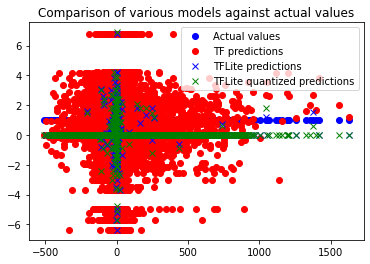

In [17]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)

y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

# Compare predictions

x_test = np.asarray(x_test).astype(int)
y_test = np.asarray(y_test).astype(int)
y_test_pred_no_quant_tflite = y_test_pred_no_quant_tflite.reshape(400, 714)
y_test_pred_tflite = y_test_pred_tflite.reshape(400, 714)

plt.title("Comparison of various models against actual values")
ax = plt.plot(x_test, y_test, "bo", label="Actual values")
ay = plt.plot(x_test, y_test_pred_tf, "ro", label="TF predictions")
aq = plt.plot(x_test, y_test_pred_no_quant_tflite, "bx", label="TFLite predictions")
az = plt.plot(x_test, y_test_pred_tflite, "gx", label="TFLite quantized predictions")

plt.legend(handles=[ax[0], ay[0], aq[0], az[0]])

plt.show()

### Size

In [18]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [19]:
# Compare size
pd.DataFrame.from_records(
    [
        ["TensorFlow", f"{size_tf} bytes", ""],
        [
            "TensorFlow Lite",
            f"{size_no_quant_tflite} bytes ",
            f"(reduced by {size_tf - size_no_quant_tflite} bytes)",
        ],
        [
            "TensorFlow Lite Quantized",
            f"{size_tflite} bytes",
            f"(reduced by {size_no_quant_tflite - size_tflite} bytes)",
        ],
    ],
    columns=["Model", "Size", ""],
    index="Model",
)

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,48564 bytes,(reduced by -44468 bytes)
TensorFlow Lite Quantized,14160 bytes,(reduced by 34404 bytes)


## Generating a TensorFlow Lite Model for Microcontrollers

In [20]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i "s/model/g_model/" {MODEL_TFLITE_MICRO}

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpa